# Demo of newtonian noise code

The goal is to reproduce one of the plots from the old matlab code

## Setup

In [1]:
# Standard inputs
import numpy as np
from matplotlib import pyplot as plt

# Add parent directory to path
import os,sys
parentdir=os.path.dirname(os.path.abspath('.'))
sys.path.insert(0,parentdir)

# Import classes for newtonian noise
from TestMass import TestMass
from CoherentSeismicField import CoherentSeismicField

In [2]:
# Constants
G_SI=6.673e-11
km_SI=1000
feet = 0.3048 # meters

## Initialize seismic field

In [3]:
# Initialize frequency array and seismic field object
freqs=np.arange(0.5,5.1,0.5)
csf=CoherentSeismicField(freqs)

# Read in eigenfunction data
seismicfile='../data/Rwave_params_20180423'
csf.readSeismicDataFromFile(seismicfile)

# Read in radiometer map data
map_top_dir='../data/radiometer_maps/1117324816/'
map_data_dirs=['0_5_Hz/','1_0_Hz/','1_5_Hz/','2_0_Hz/','2_5_Hz/',
               '3_0_Hz/','3_5_Hz/','4_0_Hz/','4_5_Hz/','5_0_Hz/']
mapdirs=[map_top_dir+x for x in map_data_dirs]
mapfile='MAPS-1117324816-1117332016.mat'
csf.readMapFromFile_Incoherent_RemoveNegativePixels(mapdirs,mapfile)

# Read in data for ASD
asd_top_dir='../data/asds/1117324816/'
asd_data_dirs=['0_5_Hz/','1_0_Hz/','1_5_Hz/','2_0_Hz/','2_5_Hz/',
               '3_0_Hz/','3_5_Hz/','4_0_Hz/','4_5_Hz/','5_0_Hz/']
asd_dirs=[asd_top_dir+x for x in asd_data_dirs]
asd_filename='MAPS-1117324816-1117332016.mat'
csf.renormalizeMaps(asd_dirs,asd_filename) # rescale radiometer maps based on measured ASD

## Construct Newtonian Noise estimate

First, initialize some parameters

In [4]:
L=40*km_SI
m=40 #kg
depths = feet*np.array([0,800,4850])
newtonian_noise={}

Then, consider several versions of a next generation experiment at different depths.

Compute the (fourier transform of the) acceleration for each test mass in each experiment.

In [5]:
for depth in depths:
    # To mimic matlab code, take (x,y) positions to both be zero for all test masses
    x_ITMX=np.array([0,0,-depth])
    x_ITMY=np.array([0,0,-depth])
    x_ETMX=np.array([0,0,-depth]) 
    x_ETMY=np.array([0,0,-depth])

    # Initialize TestMass objects
    ITMX=TestMass('ITMX',x_ITMX,m,freqs)
    ITMY=TestMass('ITMY',x_ITMY,m,freqs)
    ETMX=TestMass('ETMX',x_ETMX,m,freqs)
    ETMY=TestMass('ETMY',x_ETMY,m,freqs)

    masses=[ITMX,ITMY,ETMX,ETMY]

    # Compute acceleration for each mass
    for mass in masses:
        mass.get_acceleration_budget(csf)
        for ii,freq in enumerate(mass.freqs):
            a=mass.acceleration[freq]
        newtonian_noise_sq=np.zeros(freqs.shape)
        newtonian_noise[depth]=np.zeros(freqs.shape)

Compute the newtonian noise in each experiment, by summing over the test masses.

In [6]:
for depth in depths:
    # Compute newtonian noise by summing over masses
    for ii,freq in enumerate(freqs):
        for mass in masses:
            a=mass.acceleration[freq]
            newtonian_noise_sq[ii]+=np.abs( a[0]/L/(2*np.pi*freq)**2 )**2
        newtonian_noise[depth][ii]=np.sqrt(newtonian_noise_sq[ii])

## Plot results

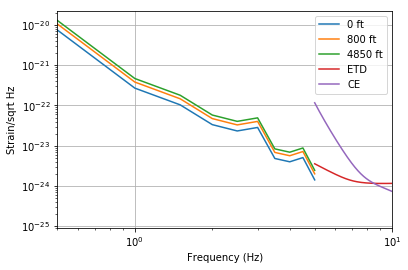

In [7]:
for depth in depths:
    plt.loglog(freqs,newtonian_noise[depth],label='%d ft'%int(depth/feet))
freqDet,ALIGO,ETD,CE,CEWB,CEPESS=np.loadtxt('../data/CE_ASD_P1600143-v18.dat',unpack=True)
plt.loglog(freqDet,ETD,label='ETD')
plt.loglog(freqDet,CE,label='CE')
plt.xlim([0.5,10])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain/sqrt Hz')
plt.grid()
plt.legend()
plt.show()
